# Time Series Prediction with ARIMA

In this notebook we're going to investigate the topic of time series prediction. As an example of time series we took [number of international airlines passangers](https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line) from January 1949 to December 1960. In total we 12 years of monthly data which means 144 points.

The goal is to predict the traffic for the next 3 years.

In [1]:
options(warn=-1)

In [2]:
library("forecast")
library("tseries")
library("lmtest")
library("Hmisc")
library("repr")

Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: lattice
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2

Attaching package: 'Hmisc'

The following objects are masked from 'package:base':

    format.pval, round.POSIXt, trunc.POSIXt, units



# Reading data

Let's take a look into initial data

In [3]:
data <- read.csv("./international-airline-passengers.csv", header=TRUE)

colnames(data) <- c("Date", "Passengers")
data$Date <- as.Date(as.yearmon(data$Date, format="%Y-%m"))

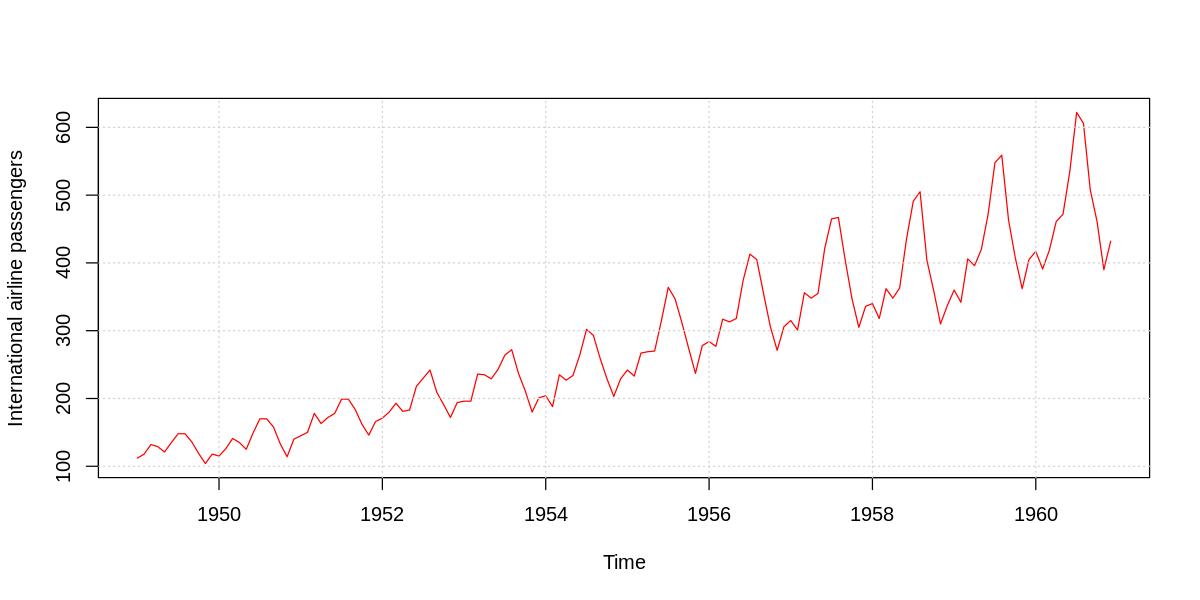

In [4]:
tSeries <- ts(data = data$Passengers, 
              start = as.numeric(c(format(data$Date[1], "%Y"), format(data$Date[1], "%m"))), 
              freq = 12)
xname <- "International airline passengers"
options(repr.plot.width=10, repr.plot.height=5)
plot(tSeries, type="l", 
     ylab=xname, 
     col="red")
grid()

# Data preprocessing

First of all, let's split our data into train and test. We need to do a prediction with 36 months horizont. Thus it is reasinable to have 36 points in test set. Also it is important to have them in chronological order. A good practice here is to take last points if the the series. Let's do like that.

In [5]:
trainSeries <- window(tSeries, end=c(1957,12))
testSeries  <- window(tSeries, start=c(1958,1))
D = 36

Then let's see how the STL (Seasonal-Trend) decomposition looks like

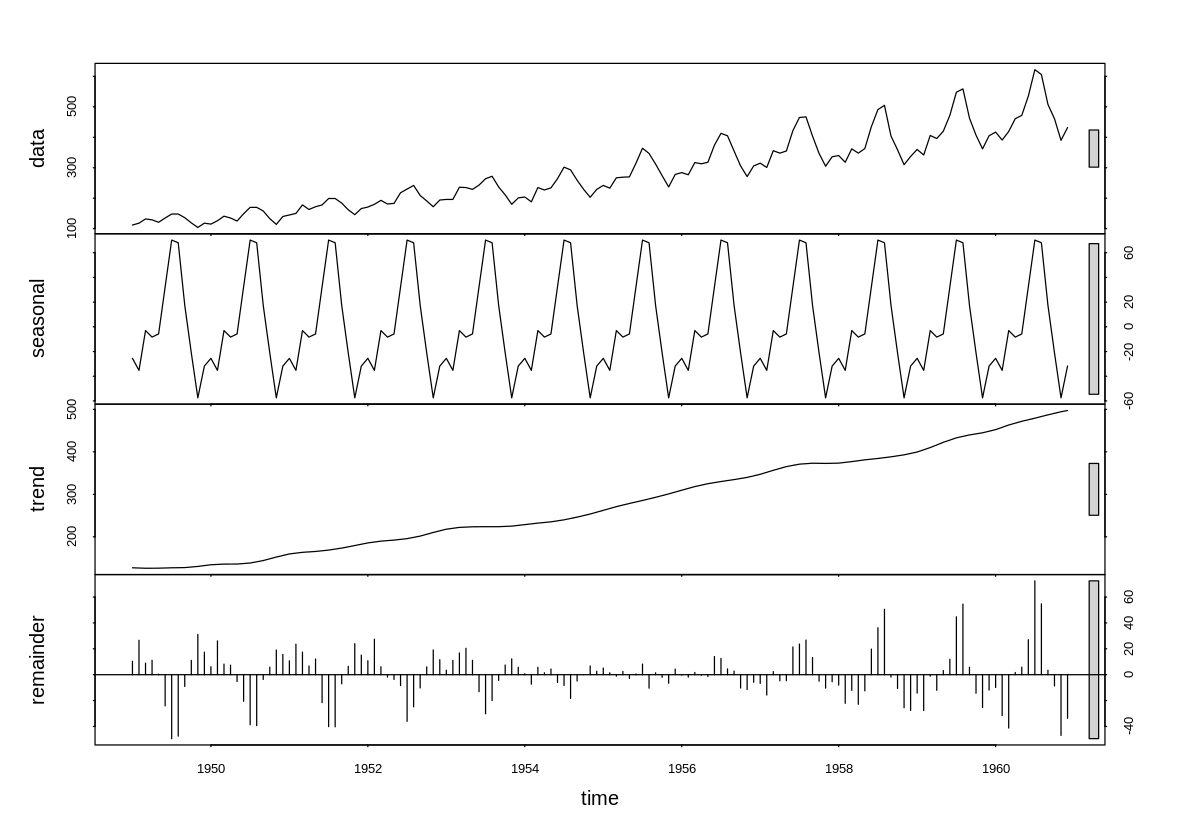

In [6]:
options(repr.plot.width=10, repr.plot.height=7)
plot(stl(tSeries, s.window="periodic"))

Initial time series is [heteroscedastic](https://en.wikipedia.org/wiki/Heteroscedasticity) (which means unstable variance). It is unwanted effect for classical algorithms.

First (and easiest) thing to try in case of monthly data - divide each point by the number of days in month.

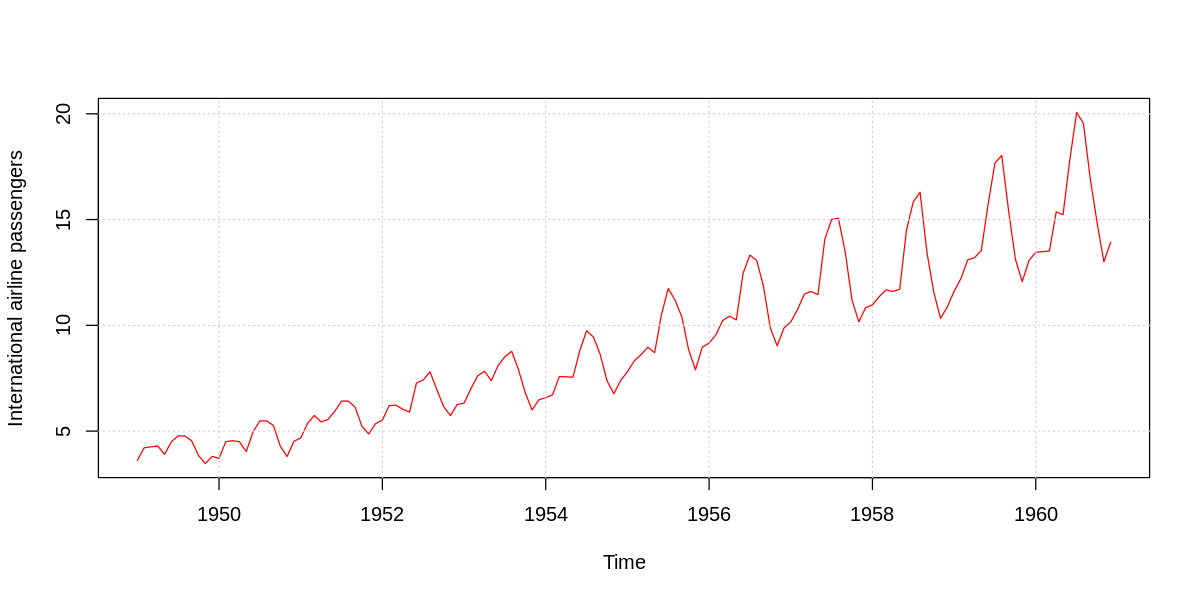

In [7]:
options(repr.plot.width=10, repr.plot.height=5)
plot(tSeries / monthDays(as.Date(time(tSeries))), type="l", ylab=xname, col="red")
grid()

As one can see above time series does not become more regular. Let's come back to the initial data though.

Next thing to try is [Box-Cox](https://en.wikipedia.org/wiki/Power_transform) transformation:

$$
\hat{y}_i =
\begin{cases}
\dfrac{y_i^\lambda - 1}{\lambda} & \text{if } \lambda \neq 0, \\[8pt]
\ln{(y_i)} & \text{if } \lambda = 0,
\end{cases}
$$

Let's find optimal value of $\lambda$ in Box-Cox transformation:

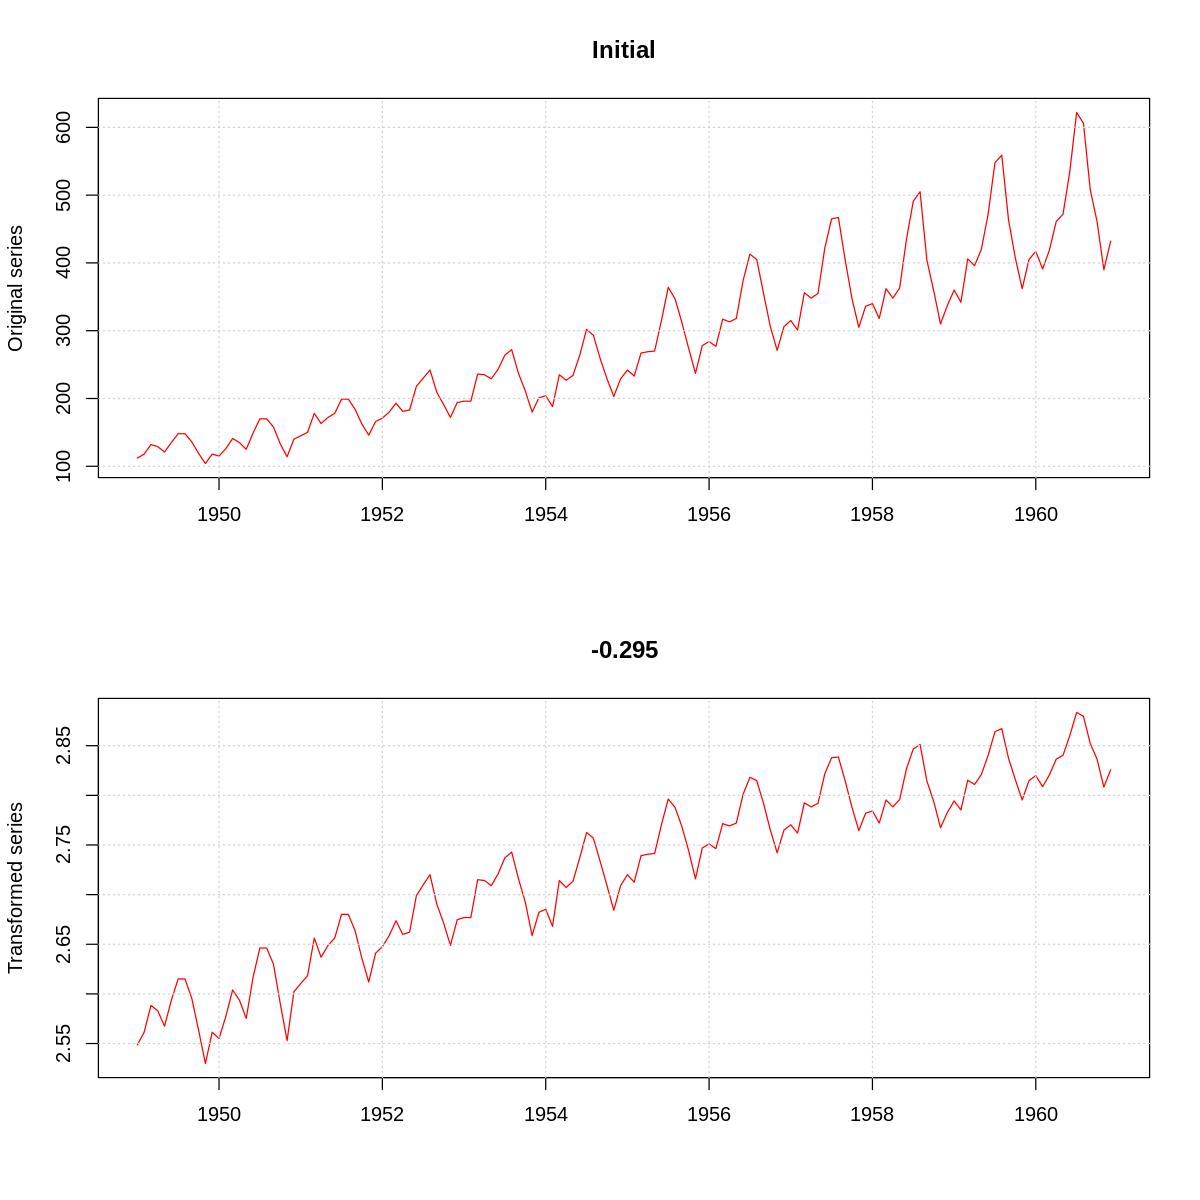

In [8]:
options(repr.plot.width=10, repr.plot.height=10)
par(mfrow=c(2,1))
plot(tSeries, ylab="Original series", xlab="", col="red")
title(main="Initial")
grid()

LambdaOpt <- BoxCox.lambda(tSeries)
plot(BoxCox(tSeries, LambdaOpt), ylab="Transformed series", xlab="", col="red")
title(main=toString(round(LambdaOpt, 3)))
grid()

Box-Cox stabilizes variance well. So we're going to use it further (but with slightly rounded $\lambda = -0.3$)

In [9]:
LambdaOpt = -0.3

STL-decomposition for transformed series

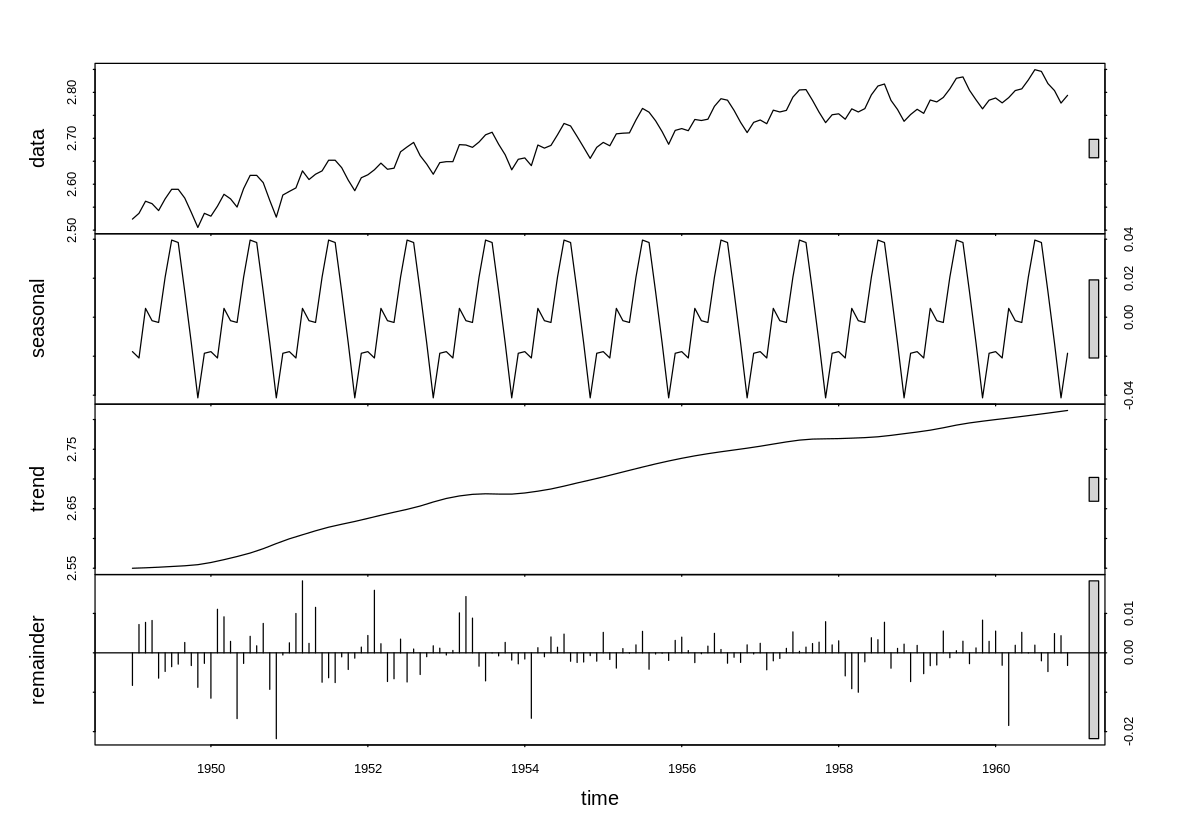

In [10]:
options(repr.plot.width=10, repr.plot.height=7)
plot(stl(BoxCox(tSeries, LambdaOpt), s.window="periodic"))

# Models

In this notebook we take a look into two models - ETS and ARIMA (both manually and automatically selected)

## ETS model

First model we're going to explore is exponential smooting model with trend and seasonality. The general framework is called ETS (Error Trend Seasonality). One can learn more [here](http://robjhyndman.com/talks/RevolutionR/6-ETS.pdf) and [here](https://www.otexts.org/fpp/7/). 

Briefly, there is three options (None, Additive and Multiplicative) for trend and seasonality and two (Additive and Multiplicative) for error. The best model among all possible is selected using [Akaike information criterion with correction](https://en.wikipedia.org/wiki/Akaike_information_criterion) (modified version of Maximal Likelihood criterion).

In [11]:
fit.ets <- ets(tSeries, lambda=LambdaOpt)
res.ets <- residuals(fit.ets)
fit.ets

ETS(A,A,A) 

Call:
 ets(y = tSeries, lambda = LambdaOpt) 

  Box-Cox transformation: lambda= -0.3 

  Smoothing parameters:
    alpha = 0.3872 
    beta  = 0.0045 
    gamma = 1e-04 

  Initial states:
    l = 2.544 
    b = 0.0021 
    s=-0.0196 -0.0419 -0.0132 0.0119 0.0381 0.0398
           0.0206 -0.0024 -0.0015 0.0051 -0.0201 -0.0167

  sigma:  0.0072

      AIC      AICc       BIC 
-670.8618 -666.0046 -620.3750 

Here the {{fit.ets$method}} model is chosen.

Now let's train just selected model on train set and measure the quality using test set.

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.02809668,7.175769,5.721227,-0.0027264,2.662989,0.1871338,0.1546686,NA
Test set,-75.67578738,84.170372,75.675787,-17.2560047,17.256005,2.4752557,0.6381408,1.697846


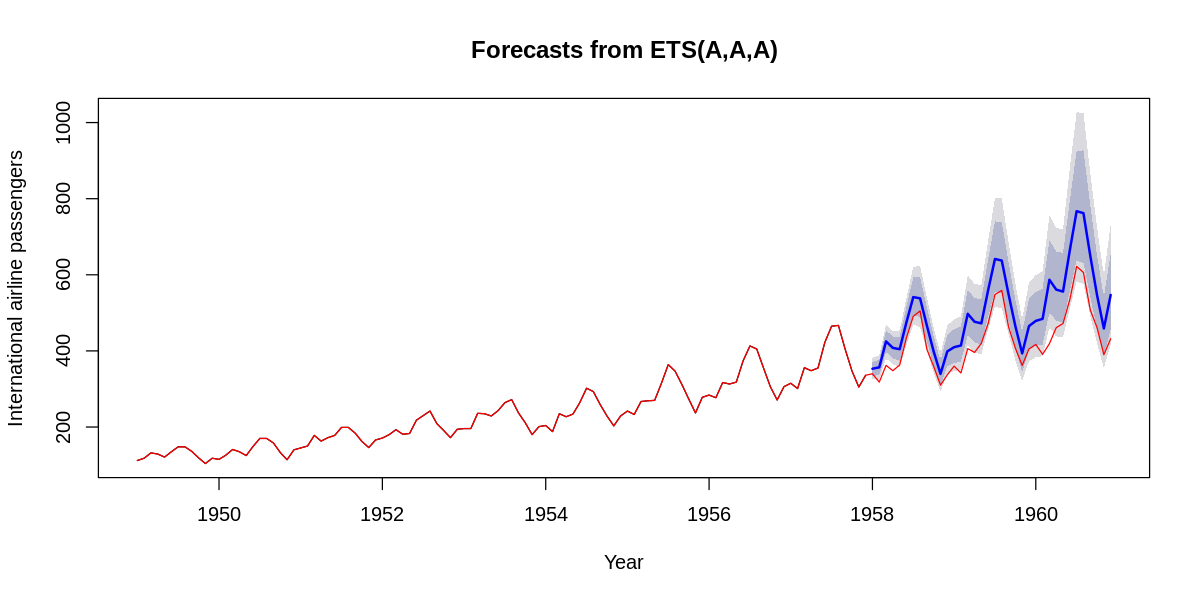

In [12]:
fitShort <- ets(trainSeries, 
                model=paste(fit.ets$components[1:3], sep="", collapse=""),
                damped=as.logical(fit.ets$components[4]), 
                lambda=LambdaOpt)
fc       <- forecast(fitShort, 
                     h=D, 
                     lambda=LambdaOpt, 
                     bootstrap=T)
options(repr.plot.width=10, repr.plot.height=5)
plot(fc, 
     ylab=xname, 
     xlab="Year")
lines(tSeries, col="red")
accuracy(fc, testSeries)

Model looks not so bad, but it tends to overestimate real values.

Let's explore residuals to get better understanding whether we can statistically improve the model or not.

There are three necessary conditions for model to be good (all of them should be applied to the residuals):

* Lack of autocorrelation (checked via [Ljung-Box](https://en.wikipedia.org/wiki/Ljung%E2%80%93Box_test) test)
* Stationarity (checked via [KPSS](https://en.wikipedia.org/wiki/KPSS_test) test)
* No bias (checked via [Wilcoxon](https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test) test)

Two more desirable (but not necessary) conditions:

* Normality (checked via e.g [Shapiro-Wilk](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test) test)
* Homoskedasticity (checked via [Breusch-Pagan](https://en.wikipedia.org/wiki/Breusch%E2%80%93Pagan_test) test)

The latter two properties allow to construct confidence intervals theoretically. Otherwise it is usually done using [bootstrap](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)).

The residuals of the best ETS model:

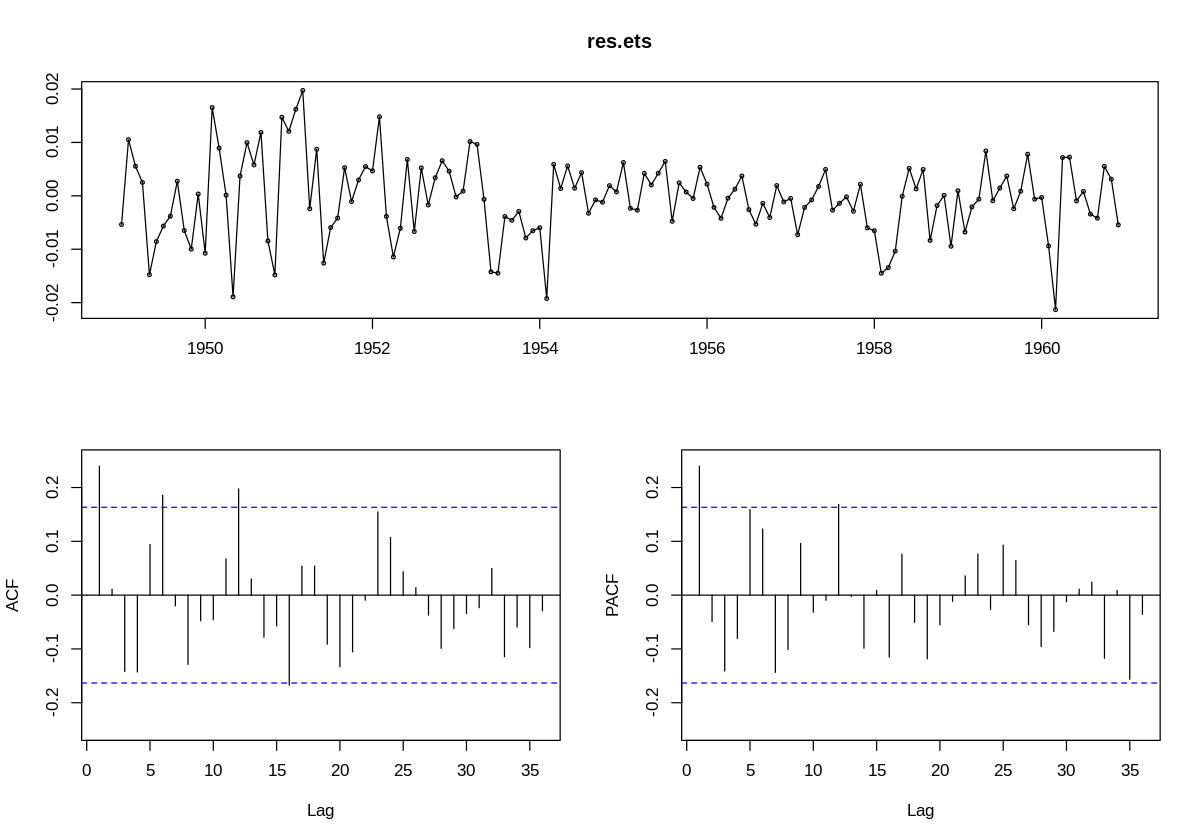

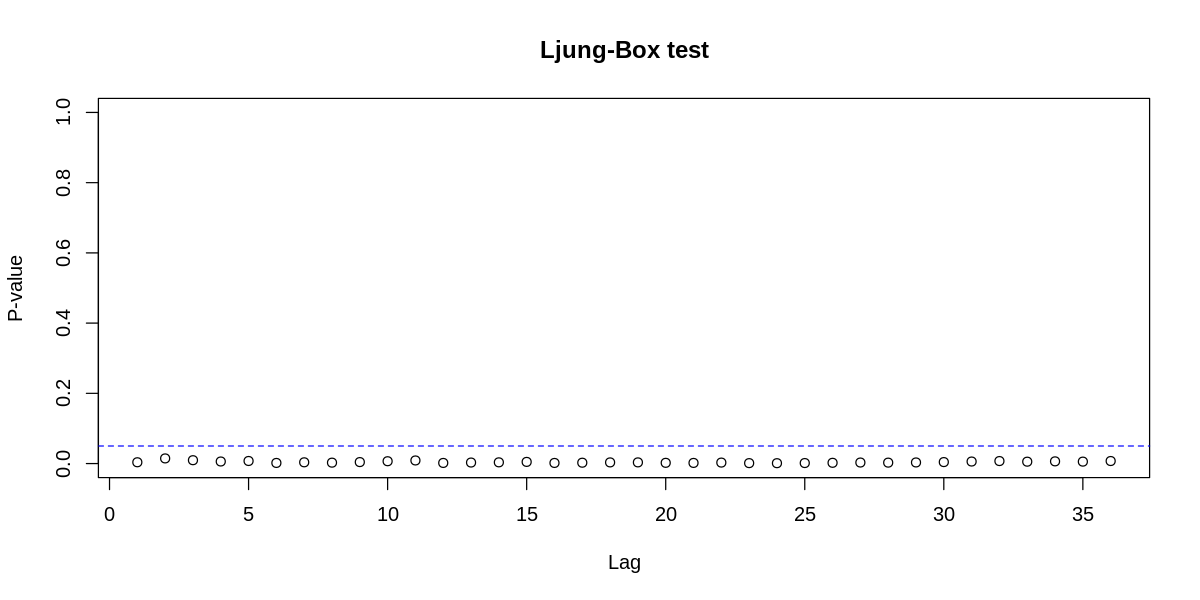

In [13]:
options(repr.plot.width=10, repr.plot.height=7)
tsdisplay(res.ets)

p <- rep(0, 1, frequency(tSeries)*3)
for (i in 1:length(p)){
  p[i] <- Box.test(res.ets, lag=i, type = "Ljung-Box")$p.value
}
options(repr.plot.width=10, repr.plot.height=5)
plot(p, xlab="Lag", ylab="P-value", main="Ljung-Box test", ylim=c(0,1))
abline(h = 0.05, lty = 2, col = "blue")

As one can see from the Ljung-Box test the residuals are self-correlated. It can mean that the model is not so good.

Below one can find analysis of four other properties of the residuals:

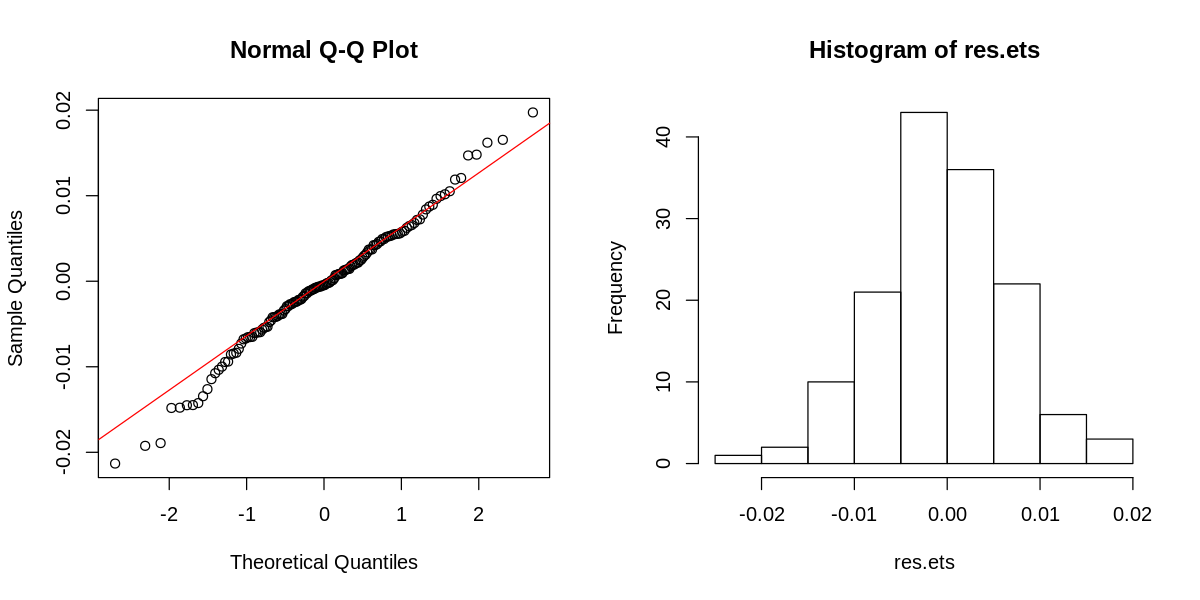

In [14]:
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow=c(1,2))
qqnorm(res.ets)
qqline(res.ets, col="red")
hist(res.ets)

Let's define an utility function that tells whether hypothesis rejected or not with the significance level $0.05$

In [15]:
check <- function(a)
{
  if (a < 0.05)
  {
    return("Rejected")
  }
  else
  {
    return("Not Rejected")
  }
}

And run all the tests described above

In [16]:
sh <- shapiro.test(res.ets)$p.value
wi <- wilcox.test(res.ets)$p.value
kp <- kpss.test(res.ets)$p.value
bp <- bptest(res.ets ~ c(1:length(res.ets)))$p.value[["BP"]]

Hypothesis         | Test          | Result             | p-value
------------------ | ------------- | ------------------ | ------------------------------
Stationarity       | KPSS          | {{check(kp)}}      | {{round(kp, 4)}}
Unbiased           | Wilcoxon      | {{check(wi)}}      | {{round(wi, 4)}}
Normality          | Shapiro-Wilk  | {{check(sh)}}      | {{round(sh, 4)}}
Homoskedasticity   | Breusch-Pagan | {{check(bp)}}      | {{round(bp, 4)}}

Finally we get normal, unbiased, stationary, heteroskedastic (that's why we used $\text{bootstrap = T}$ in forecasting) and autocorrelated residuals.

Because of the autocorrelation we can conclude that not all the information is extracted from the time series and we can build a better model.

## ARIMA

### Manual model selection

Initial time series is not stationary (p < {{kpss.test(BoxCox(tSeries, LambdaOpt))$p.value}}, KPSS test). Let's apply seasonal differentiation (with period equals to 12) to get rid of seasonality:

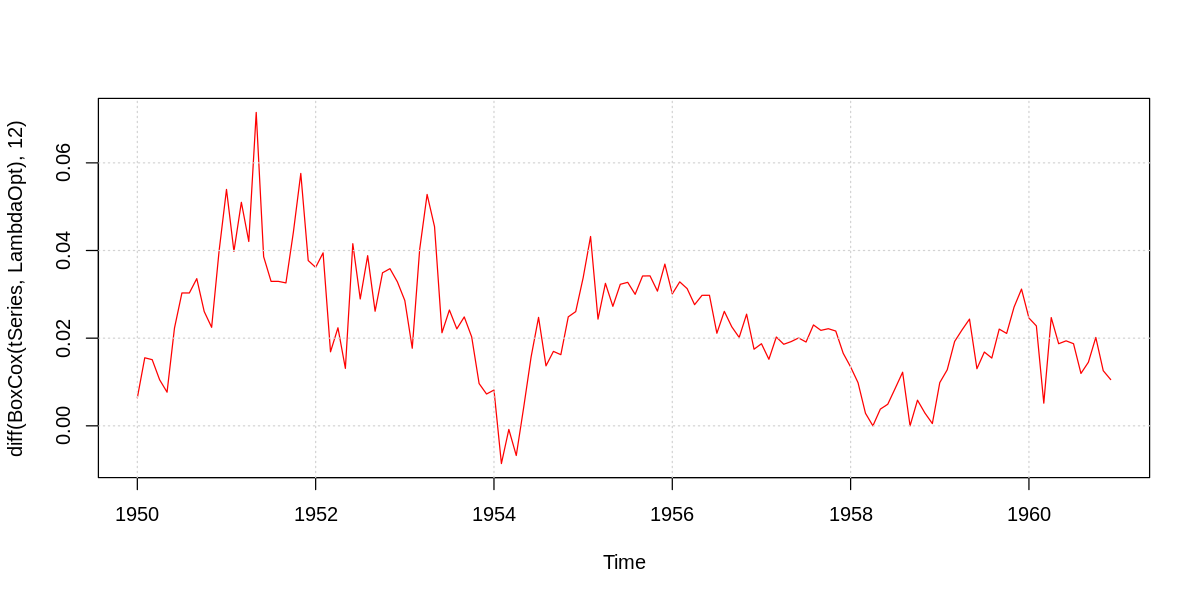

In [17]:
options(repr.plot.width=10, repr.plot.height=5)
plot(diff(BoxCox(tSeries, LambdaOpt), 12), type="l", col="red")
grid()

Obtained series is still non-stationary. It is obvious from the visual inpection and is confirmed by statictical test (p < {{kpss.test(diff(BoxCox(tSeries, LambdaOpt), 12))$p.value}}, KPSS test)

Let's apply simple differentiation to get rid of trend in the initial data:

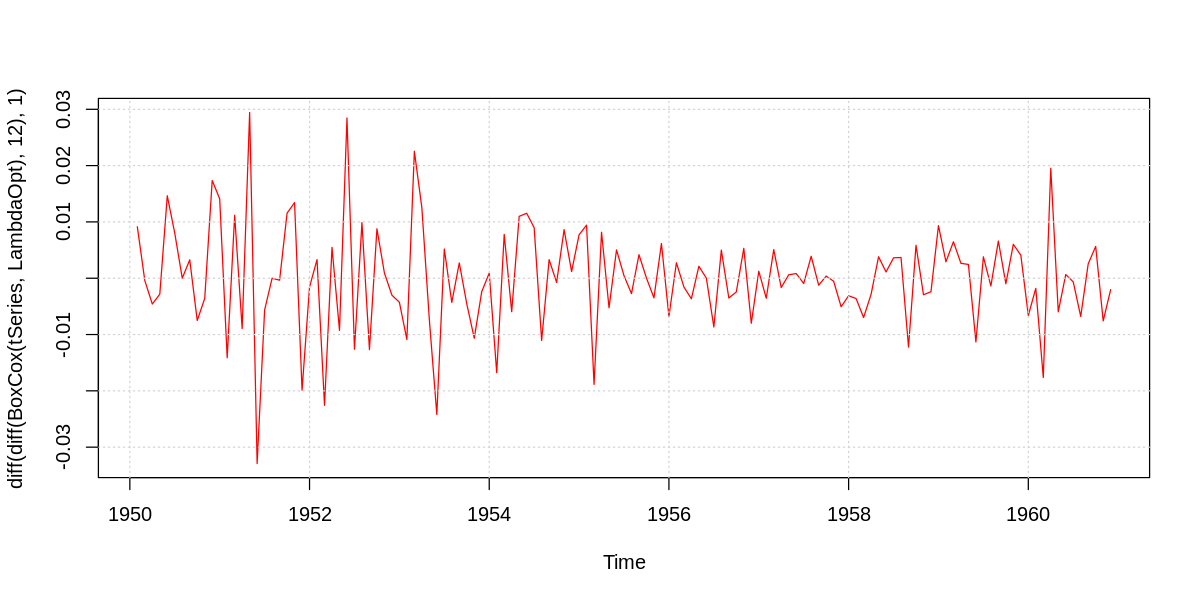

In [18]:
options(repr.plot.width=10, repr.plot.height=5)
plot(diff(diff(BoxCox(tSeries, LambdaOpt), 12), 1), type="l", col="red")
grid()

Now time series is stationary(p > {{kpss.test(diff(diff(BoxCox(tSeries, LambdaOpt), 12), 1))$p.value}}, KPSS test).

Next step is to determine what components of AutoRegression (AR) and Moving Average (MA) do we need in our final ARIMA model.

For that purpose we need to investigate ACF and PACF (see [here](https://www.otexts.org/fpp/8/9) for further details):

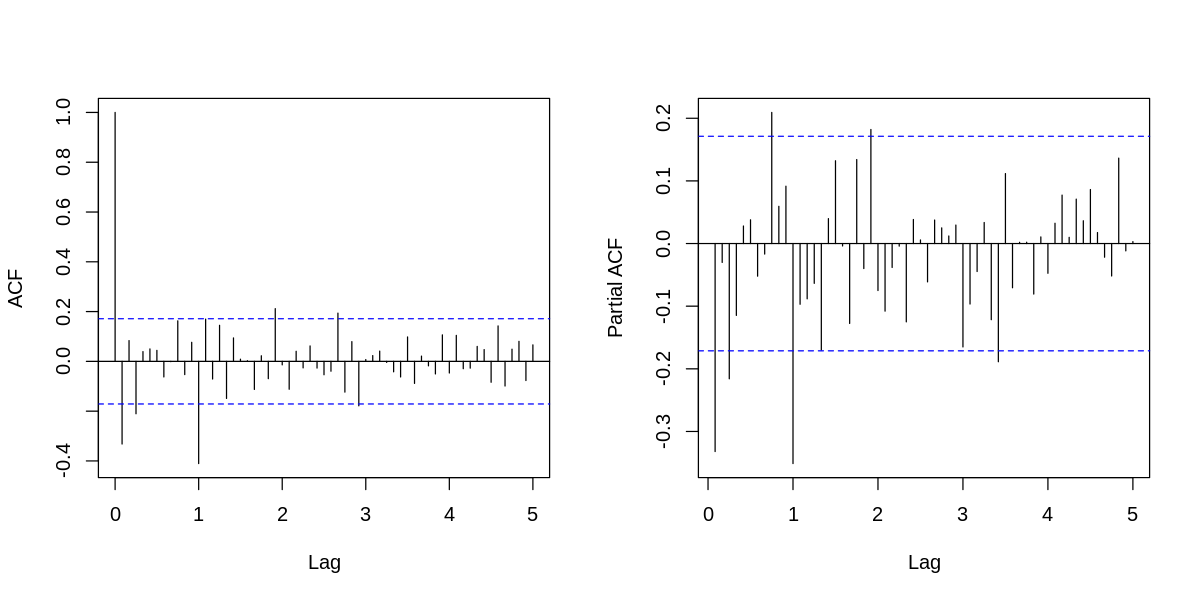

In [19]:
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow=c(1,2))
acf(diff(diff(BoxCox(tSeries, LambdaOpt), 12), 1), lag.max=5*12, main="")
pacf(diff(diff(BoxCox(tSeries, LambdaOpt), 12), 1), lag.max=5*12, main="")

From the graphs above one can see that in the ACF we have lags 1, 3 and 12 statistical significant and 1, 3, 9, 12 in PACF. So we're going to find optimal model in the neighborhood of ARIMA(3,1,3)(1,1,1)$_{12}$

In [20]:
ar1  <- Arima(tSeries, order=c(3,1,3), seasonal=c(1,1,1), lambda=LambdaOpt)$aicc
ar2  <- Arima(tSeries, order=c(2,1,3), seasonal=c(1,1,1), lambda=LambdaOpt)$aicc
ar3  <- Arima(tSeries, order=c(3,1,2), seasonal=c(1,1,1), lambda=LambdaOpt)$aicc
ar4  <- Arima(tSeries, order=c(3,1,3), seasonal=c(1,1,0), lambda=LambdaOpt)$aicc
ar5  <- Arima(tSeries, order=c(3,1,4), seasonal=c(1,1,1), lambda=LambdaOpt)$aicc
ar6  <- Arima(tSeries, order=c(3,1,3), seasonal=c(1,1,2), lambda=LambdaOpt)$aicc
ar7  <- Arima(tSeries, order=c(2,1,2), seasonal=c(1,1,1), lambda=LambdaOpt)$aicc
ar8  <- Arima(tSeries, order=c(3,1,3), seasonal=c(0,1,1), lambda=LambdaOpt)$aicc
ar9  <- Arima(tSeries, order=c(1,1,3), seasonal=c(0,1,1), lambda=LambdaOpt)$aicc
ar10 <- Arima(tSeries, order=c(1,1,3), seasonal=c(1,1,1), lambda=LambdaOpt)$aicc
ar11 <- Arima(tSeries, order=c(3,1,3), seasonal=c(0,1,2), lambda=LambdaOpt)$aicc

Model                      | AICc
-------------------------- | ------------
ARIMA(3,1,3)(1,1,1)$_{12}$ | {{ar1}}
ARIMA(2,1,3)(1,1,1)$_{12}$ | {{ar2}}
ARIMA(3,1,2)(1,1,1)$_{12}$ | {{ar3}}
ARIMA(3,1,3)(1,1,0)$_{12}$ | {{ar4}}
ARIMA(3,1,4)(1,1,1)$_{12}$ | {{ar5}}
ARIMA(3,1,3)(1,1,2)$_{12}$ | {{ar6}}
ARIMA(2,1,2)(1,1,1)$_{12}$ | {{ar7}}
ARIMA(3,1,3)(0,1,1)$_{12}$ | {{ar8}}
ARIMA(1,1,3)(0,1,1)$_{12}$ | {{ar9}}
ARIMA(1,1,3)(1,1,1)$_{12}$ | {{ar10}}
ARIMA(3,1,3)(0,1,2)$_{12}$ | {{ar11}}

The criterion to choose on is AICc (previosuly used Akaike information criterion with correction). The best model judging by this cretirion is ARIMA(3,1,3)(0,1,1)$_{12}$

Let's investigate it deeper:

Series: tSeries 
ARIMA(3,1,3)(0,1,1)[12] 
Box Cox transformation: lambda= -0.3 

Coefficients:
         ar1      ar2      ar3      ma1     ma2      ma3     sma1
      0.2052  -0.8329  -0.0156  -0.6137  1.0089  -0.5207  -0.5600
s.e.  0.1699   0.0768   0.1643   0.1470  0.0685   0.1513   0.0823

sigma^2 estimated as 5.074e-05:  log likelihood=461.91
AIC=-907.82   AICc=-906.64   BIC=-884.81

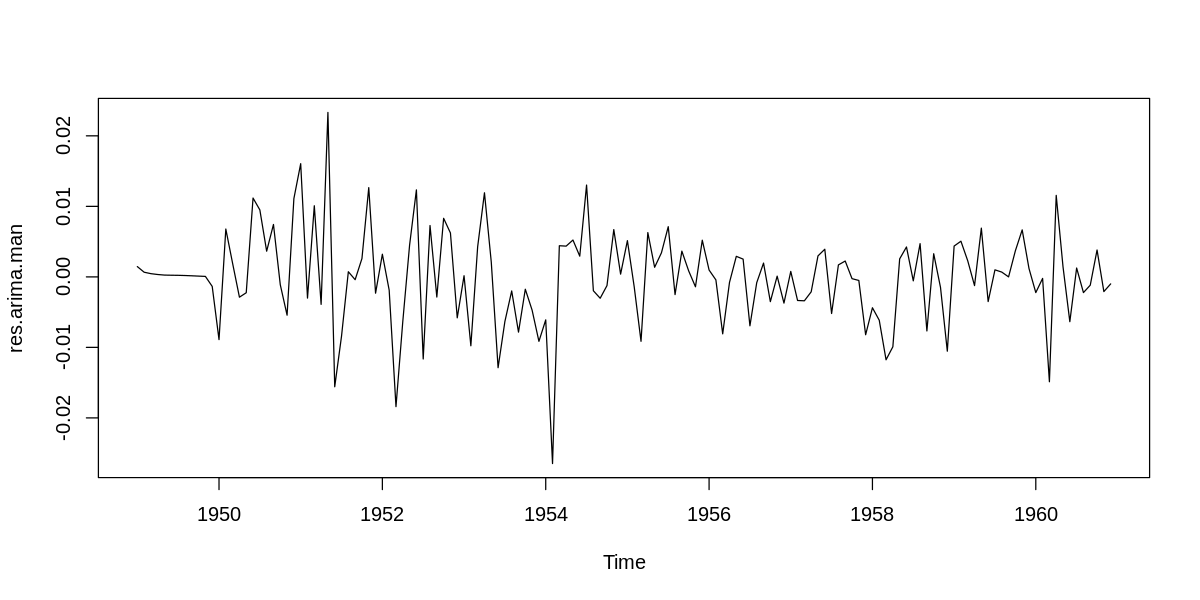

In [21]:
fit.arima.man <- Arima(tSeries, order=c(3,1,3), seasonal=c(0,1,1), lambda=LambdaOpt)
res.arima.man <- residuals(fit.arima.man)
fit.arima.man
options(repr.plot.width=10, repr.plot.height=5)
plot(res.arima.man)

Let's cut off first 12 points of residual series to make our analysis correct. It should be done because our model is seasonal and need to look 12 points back to make a prediction.

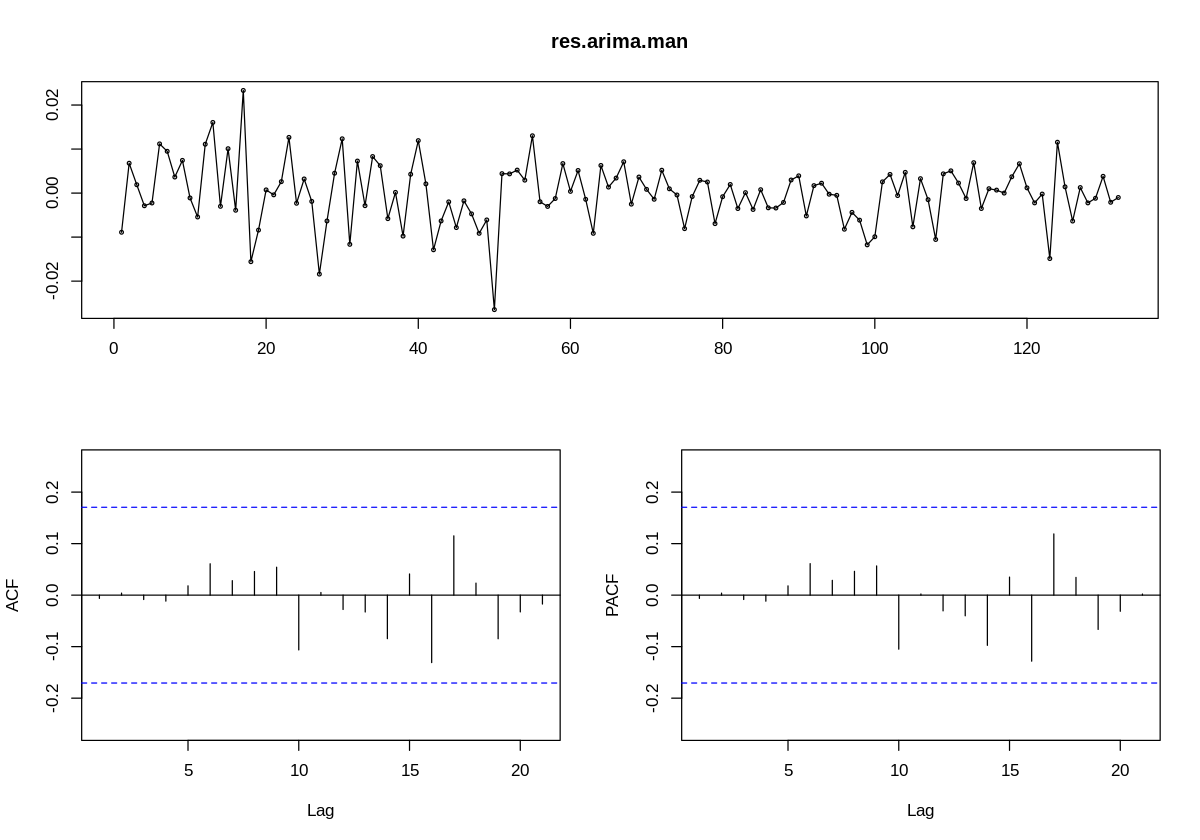

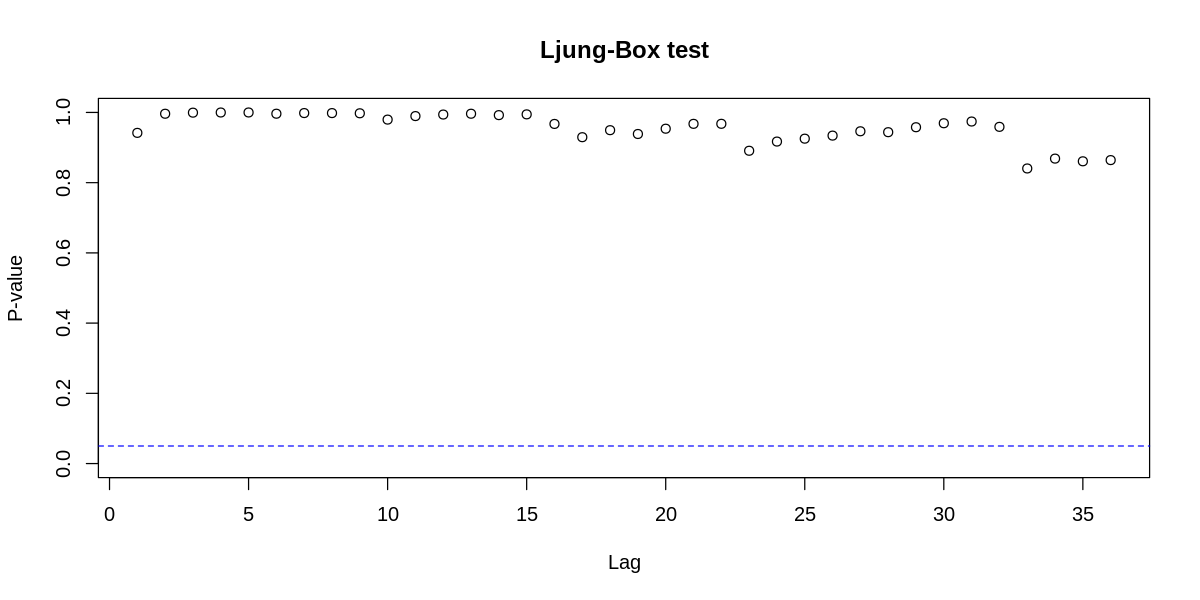

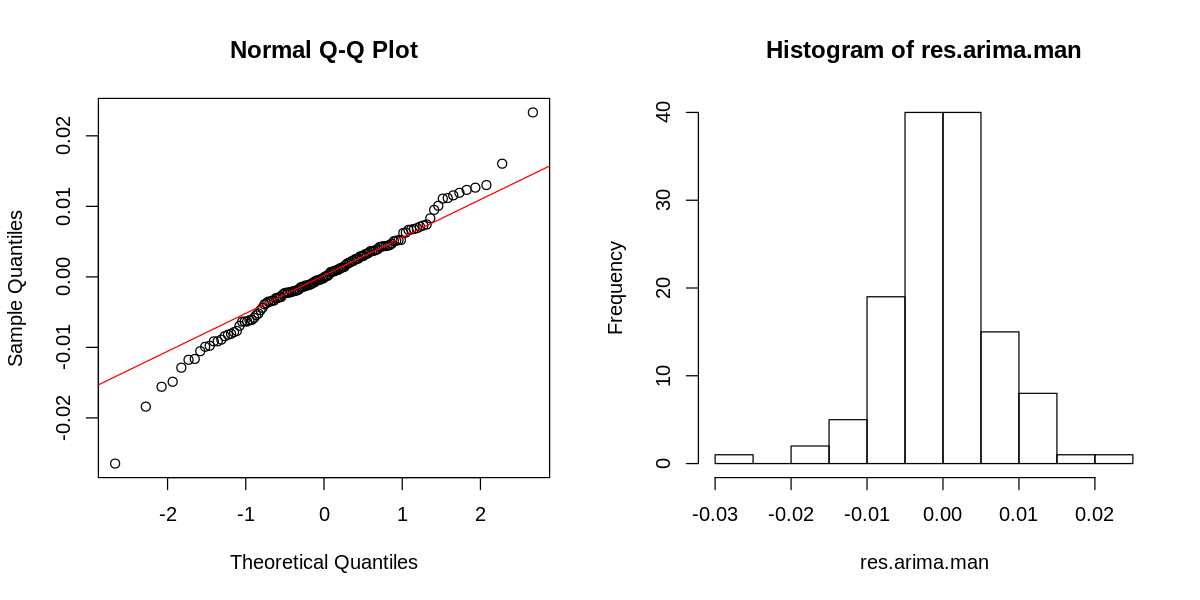

In [22]:
options(repr.plot.width=10, repr.plot.height=7)
res.arima.man <- res.arima.man[-c(1:12)]
tsdisplay(res.arima.man)

p <- rep(0, 1, frequency(tSeries)*3)
for (i in 1:length(p)){
  p[i] <- Box.test(res.arima.man, lag=i, type = "Ljung-Box")$p.value
}
options(repr.plot.width=10, repr.plot.height=5)
plot(p, xlab="Lag", ylab="P-value", main="Ljung-Box test", ylim=c(0,1))
abline(h = 0.05, lty = 2, col = "blue")

options(repr.plot.width=10, repr.plot.height=5)
par(mfrow=c(1,2))
qqnorm(res.arima.man)
qqline(res.arima.man, col="red")
hist(res.arima.man)

In [23]:
sh <- shapiro.test(res.arima.man)$p.value
wi <- wilcox.test(res.arima.man)$p.value
kp <- kpss.test(res.arima.man)$p.value
bp <- bptest(res.arima.man ~ c(1:length(res.arima.man)))$p.value[["BP"]]

Hypothesis         | Test          | Result             | p-value
------------------ | ------------- | ------------------ | ------------------------------
Stationarity       | KPSS          | {{check(kp)}}      | {{round(kp, 4)}}
Unbiased           | Wilcoxon      | {{check(wi)}}      | {{round(wi, 4)}}
Normality          | Shapiro-Wilk  | {{check(sh)}}      | {{round(sh, 4)}}
Homoskedasticity   | Breusch-Pagan | {{check(bp)}}      | {{round(bp, 4)}}

Unlike the ETS model, now we have non-autocorrelated residuals (from Ljung-Box test) but also not normal (it doesn't influence us a lot because we used bootstrap anyway)

Let's test this model. To build confidence intervals we're again going to use bootstrap because the residuals are heteroskedastic.

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.234634,7.691063,5.595787,-0.03541909,2.449544,0.1830308,-0.01525191,NA
Test set,-55.798852,61.660585,55.798852,-12.71523915,12.715239,1.8251073,0.57187043,1.237484


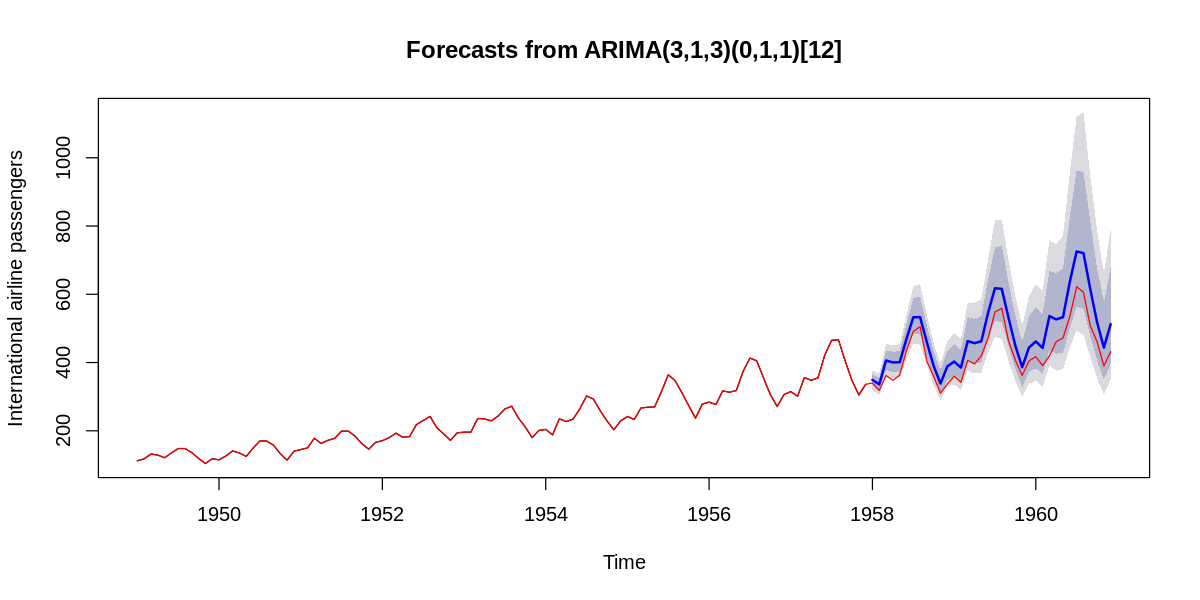

In [24]:
fitShort <- Arima(trainSeries, 
                  order=c(3,1,3), 
                  seasonal=c(0,1,1), 
                  lambda=LambdaOpt)
fc       <- forecast(fitShort, h=D, bootstrap=T)
accuracy(fc, testSeries)
options(repr.plot.width=10, repr.plot.height=5)
plot(fc, ylab=xname, xlab="Time")
lines(tSeries, col="red")

It is much better than ETS model judging on all metrics.

### Automatic model selection

R provides us with the opportunity to automatate selection of ARIMA model. But anyway inside $\text{auto.arima}$ we have some kind of exhaustive search.

In [25]:
fit.arima.auto <- auto.arima(tSeries, lambda=LambdaOpt, stepwise=F)
res.arima.auto <- residuals(fit.arima.auto)
fit.arima.auto

Series: tSeries 
ARIMA(0,1,3)(0,0,2)[12] with drift 
Box Cox transformation: lambda= -0.3 

Coefficients:
          ma1      ma2      ma3    sma1    sma2   drift
      -0.3143  -0.2282  -0.3428  0.8431  0.6964  0.0019
s.e.   0.0894   0.1074   0.0691  0.0835  0.1092  0.0003

sigma^2 estimated as 0.0001202:  log likelihood=435.75
AIC=-857.49   AICc=-856.66   BIC=-836.75

Suggested model is ARIMA(0,1,3)(0,0,2)$_{12}$. AICc value is much bigger than manually selected model has. Thus it is reasonable to assume that this model is significantly worse.

Let's investigate it.

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,2.976573,13.86349,10.37805,1.003799,4.497015,0.3394523,0.08820171,NA
Test set,48.912619,81.86164,55.72885,9.315886,11.306136,1.8228177,0.79303146,1.418286


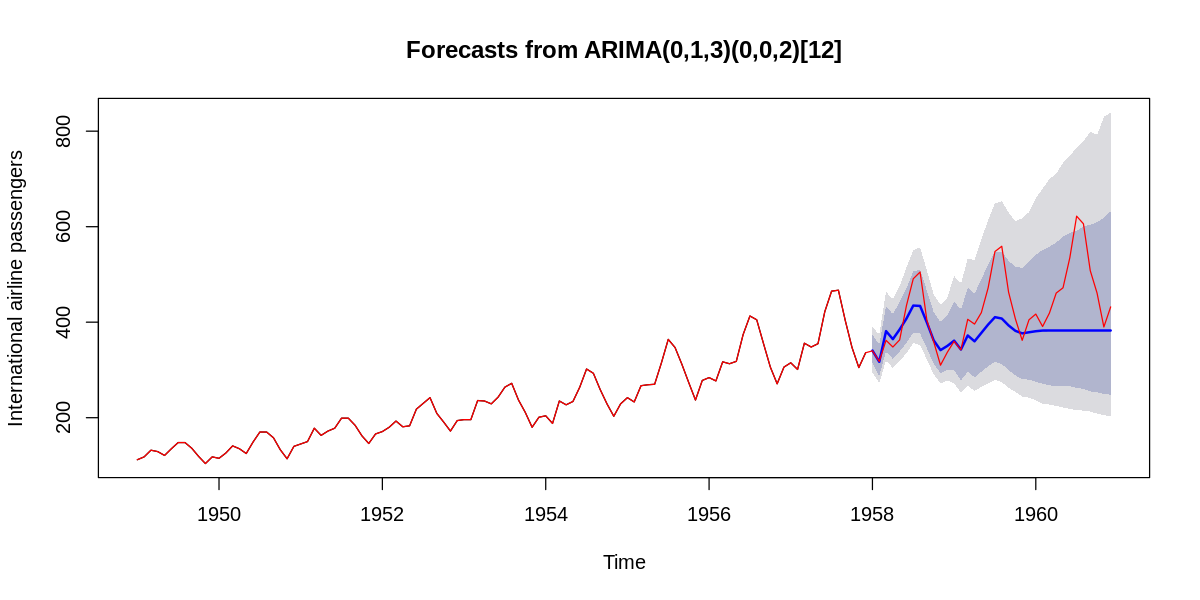

In [26]:
fitShort <- Arima(trainSeries, 
                  order=c(0,1,3), 
                  seasonal=c(0,0,2), 
                  lambda=LambdaOpt)
fc       <- forecast(fitShort, h=D, bootstrap=T)
accuracy(fc, testSeries)
options(repr.plot.width=10, repr.plot.height=5)
plot(fc, ylab=xname, xlab="Time")
lines(tSeries, col="red")

The forecast from this model is absolutely not the thing that we want to get.

Finally we choose manually selected ARIMA(3,1,3)(0,1,1)$_{12}$ model.

# Final comparison

Let's compare best ARIMA and ETS models.

For that purpose we're going to use [Diebold-Mariano test](http://www.phdeconomics.sssup.it/documents/Lesson19.pdf) which compare models judging on their residuals.


	Diebold-Mariano Test

data:  res.arima.man.originalres.ets.original
DM = -0.50095, Forecast horizon = 36, Loss function power = 2, p-value
= 0.6172
alternative hypothesis: two.sided


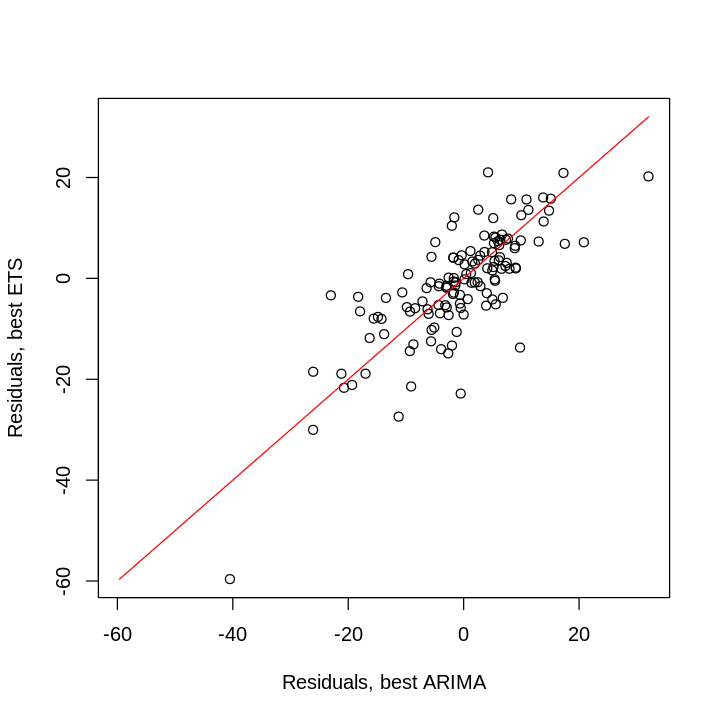

In [27]:
options(repr.plot.width=6, repr.plot.height=6)

res.arima.man.original <- (tSeries - fitted(fit.arima.man))[-c(1:12)]
res.ets.original <- (tSeries - fitted(fit.ets))[-c(1:12)]

plot(res.arima.man.original, res.ets.original, 
     xlab="Residuals, best ARIMA",
     ylab="Residuals, best ETS",
     xlim=c(min(c(res.arima.man.original, res.ets.original), na.rm=T), 
            max(c(res.arima.man.original, res.ets.original), na.rm=T)),
     ylim=c(min(c(res.arima.man.original, res.ets.original), na.rm=T), 
            max(c(res.arima.man.original, res.ets.original), na.rm=T)))

lines(c(min(c(res.arima.man.original, res.ets.original), na.rm=T), 
        max(c(res.arima.man.original, res.ets.original), na.rm=T)), 
      c(min(c(res.arima.man.original, res.ets.original), na.rm=T), 
        max(c(res.arima.man.original, res.ets.original), na.rm=T)), 
      col="red")

dm.test(res.arima.man.original, res.ets.original, h=D)

From this test one can conclude that no model is statistically better than other. But ARIMA showed better performance on the hold-out sample. Thus the final choice is ARIMA(3,1,3)(0,1,1)$_{12}$.

# Final forecast

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.234634,7.691063,5.595787,-0.03541909,2.449544,0.1830308,-0.01525191,NA
Test set,-55.798852,61.660585,55.798852,-12.71523915,12.715239,1.8251073,0.57187043,1.237484


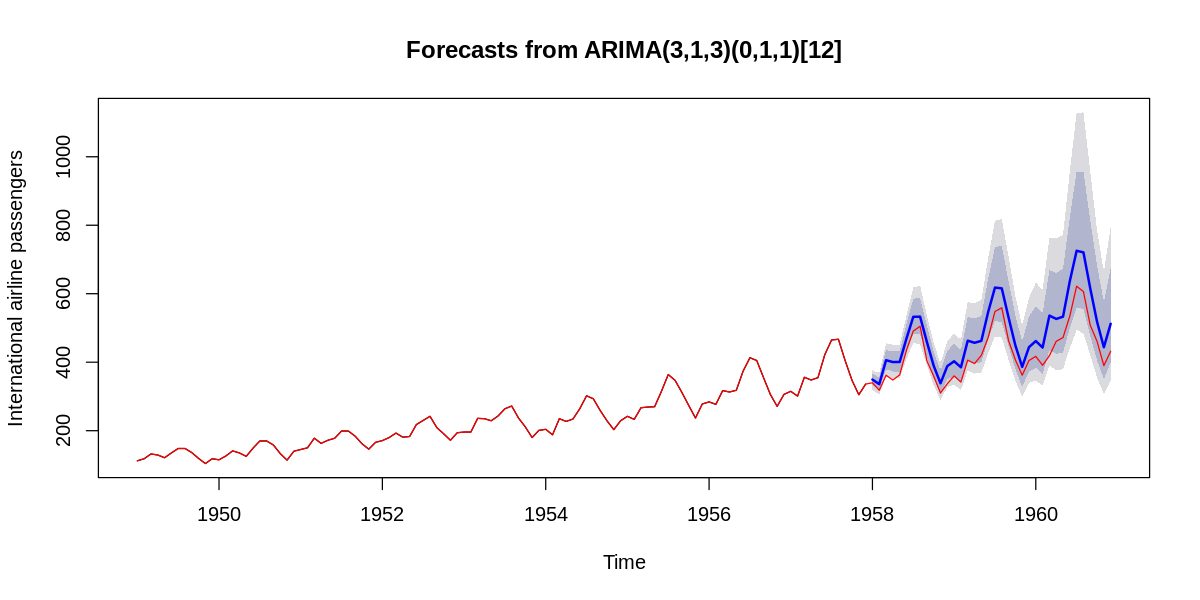

In [28]:
fitShort <- Arima(trainSeries, 
                  order=c(3,1,3), 
                  seasonal=c(0,1,1), 
                  lambda=LambdaOpt)
fc       <- forecast(fitShort, h=D, bootstrap=T)
accuracy(fc, testSeries)
options(repr.plot.width=10, repr.plot.height=5)
plot(fc, ylab=xname, xlab="Time")
lines(tSeries, col="red")